In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import re
import seaborn as sns

from google.colab import files
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

___

# 1. Load and preprocess dataset

In [0]:
uploaded = files.upload()

Saving 1-ngs_raw_dataset.csv to 1-ngs_raw_dataset.csv


In [0]:
df = pd.read_csv('./1-ngs_raw_dataset.csv')
print('Shape:', df.shape)
df.head()

Shape: (4655, 18)


,sample,chromosome,start,end,ref,alt,coding_change,protein_change,allele_frequency,read_depth,gene_refgene,exonic_func_refgene,func_refgene,1000genomes,vest3_rankscore,cosmic70,CLNSIG,database_classification
0,7902,chr13,32911756,32911756,T,C,c.3264T>C,p.(Pro1088Pro),0.428000,1189,BRCA2,synonymous_SNV,exonic,0.006789,NaN,NaN,Benign,5
1,7902,chr13,32913910,32913910,A,G,c.5418A>G,p.(Glu1806Glu),0.475531,2023,BRCA2,synonymous_SNV,exonic,0.006789,NaN,NaN,Benign,5
2,7902,chr13,32929007,32929007,G,C,c.7017G>C,p.(Lys2339Asn),0.554974,573,BRCA2,nonsynonymous_SNV,exonic,0.006789,0.380,NaN,Benign,5
3,7902,chr13,32944627,32944627,C,T,c.8420C>T,p.(Ser2807Leu),0.020000,1786,BRCA2,nonsynonymous_SNV,exonic,0.000000,0.717,"ID=COSM6612534,COSM6612533;OCCURENCE=2(large_i...",Uncertain_significance,0
4,7902,chr13,32972380,32972380,G,A,c.9730G>A,p.(Val3244Ile),0.658798,932,BRCA2,nonsynonymous_SNV,exonic,0.006789,0.366,NaN,Benign,5


In [0]:
print('Samples count:', len(df['sample'].unique()))

Samples count: 158


**Variant database classes:**
- 0: Variant not sent to database
- 1: Pathogenic
- 2: Likely pathogenic
- 3: Variant of uncertain significance
- 4: Likely benign
- 5: Benign

## 1.1 Deep dive into variables categories

### 1.1.1 Variant info

Unique identifiers for each variant. These columns basically tell us where the variant is located (`chromosome`, `start`, `end`) and what was the nucleotide change in comparison with the reference genome (`ref`, `alt`).

In [0]:
variant_info_cols = [
    'chromosome',
    'start',
    'end', 
    'ref',
    'alt',
]

df[variant_info_cols].head()

,chromosome,start,end,ref,alt
0,chr13,32911756,32911756,T,C
1,chr13,32913910,32913910,A,G
2,chr13,32929007,32929007,G,C
3,chr13,32944627,32944627,C,T
4,chr13,32972380,32972380,G,A


Variant length

`variant_length` = `end_position` - `start_position`

In [0]:
# Create variant length feature
df['variant_length'] = df[['start', 'end']].apply(lambda x: x.end - x.start + 1, axis=1) 

### 1.1.2 Sequencing data

These columns bare information related to the sequencing process: `read_depth` expresses how many reads we had for each variant and `allele_frequency` tells us the proportion of reads that presented the alternative nucleotide.

In [0]:
sequencing_data_cols = [
    'allele_frequency',
    'read_depth',
]

df[sequencing_data_cols].head()

,allele_frequency,read_depth
0,0.428000,1189
1,0.475531,2023
2,0.554974,573
3,0.020000,1786
4,0.658798,932


In [0]:
df[sequencing_data_cols].describe()

,allele_frequency,read_depth
count,4655.000000,4655.000000
mean,0.571907,1306.104834
std,0.307865,1577.659150
min,0.005000,2.000000
25%,0.428786,506.000000
50%,0.512000,891.000000
75%,0.996440,1477.500000
max,1.000000,18273.000000


We need to normalize `read_depth` within samples to avoid bias, because its absolute value is highly dependent on the sample's sequencing process.

In [0]:
for sample in df['sample'].unique():
    indexes = df[df['sample'] == sample].index
    filtered_df = df.loc[indexes]
    df.loc[indexes, 'norm_read_depth'] = filtered_df['read_depth'] / filtered_df['read_depth'].max()

In [0]:
df['norm_read_depth'].describe()

count    4655.000000
mean        0.502639
std         0.242823
min         0.001095
25%         0.312302
50%         0.490535
75%         0.672663
max         1.000000
Name: norm_read_depth, dtype: float64

### 1.1.3 Annotation data

These columns are variant metadata fetched from public databases. They help us give meaning to the nucleotide changes we found for the sample and understand the gene they're in and their impact on the protein to be synthesized.

In [0]:
annotation_data_cols = [
    'coding_change', 'protein_change', 'exonic_func_refgene',
    'func_refgene', 'gene_refgene',
]

df[annotation_data_cols].head()

,coding_change,protein_change,exonic_func_refgene,func_refgene,gene_refgene
0,c.3264T>C,p.(Pro1088Pro),synonymous_SNV,exonic,BRCA2
1,c.5418A>G,p.(Glu1806Glu),synonymous_SNV,exonic,BRCA2
2,c.7017G>C,p.(Lys2339Asn),nonsynonymous_SNV,exonic,BRCA2
3,c.8420C>T,p.(Ser2807Leu),nonsynonymous_SNV,exonic,BRCA2
4,c.9730G>A,p.(Val3244Ile),nonsynonymous_SNV,exonic,BRCA2


In [0]:
df[annotation_data_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655 entries, 0 to 4654
Data columns (total 5 columns):
coding_change          3580 non-null object
protein_change         2436 non-null object
exonic_func_refgene    4655 non-null object
func_refgene           4655 non-null object
gene_refgene           4655 non-null object
dtypes: object(5)
memory usage: 181.9+ KB


In [0]:
df[annotation_data_cols].describe()

,coding_change,protein_change,exonic_func_refgene,func_refgene,gene_refgene
count,3580,2436,4655,4655,4655
unique,500,439,7,7,14
top,c.4563A>G,p.(Val2466Ala),exonic_func_not_provided,exonic,BRCA2
freq,157,148,2215,2440,1504


Columns `gene_refgene`, `func_refgene` and `exonic_func_refgene` are categorical and should be be one-hot encoded;

In [0]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(df['gene_refgene'])

gene_categorical_df = pd.DataFrame(
    columns=label_encoder.classes_, 
    data=ohe.fit_transform(integer_encoded.reshape(-1, 1)).astype(int)
)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(df['exonic_func_refgene'])

exonic_func_categorical_df = pd.DataFrame(
    columns=label_encoder.classes_, 
    data=ohe.fit_transform(integer_encoded.reshape(-1, 1)).astype(int)
)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(df['func_refgene'])

func_refgene_categorical_df = pd.DataFrame(
    columns=label_encoder.classes_, 
    data=ohe.fit_transform(integer_encoded.reshape(-1, 1)).astype(int)
)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
df = pd.concat(
    [df, gene_categorical_df, exonic_func_categorical_df, func_refgene_categorical_df],
    axis=1,
    join_axes=[df.index]
)

df.head()

,sample,chromosome,start,end,ref,alt,coding_change,protein_change,allele_frequency,read_depth,gene_refgene,exonic_func_refgene,func_refgene,1000genomes,vest3_rankscore,cosmic70,CLNSIG,database_classification,variant_length,norm_read_depth,BRCA1,BRCA1;NBR2,BRCA2,CDH1,DCTN5,KLLN,MLH1,MSH6,NBR2,PALB2,PTEN,RB1,STK11,TP53,exonic_func_not_provided,frameshift_deletion,frameshift_insertion,nonframeshift_substitution,nonsynonymous_SNV,stopgain,synonymous_SNV,UTR3,UTR5,exonic,intronic,ncRNA_intronic,splicing,upstream
0,7902,chr13,32911756,32911756,T,C,c.3264T>C,p.(Pro1088Pro),0.428000,1189,BRCA2,synonymous_SNV,exonic,0.006789,NaN,NaN,Benign,5,1,0.573288,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,7902,chr13,32913910,32913910,A,G,c.5418A>G,p.(Glu1806Glu),0.475531,2023,BRCA2,synonymous_SNV,exonic,0.006789,NaN,NaN,Benign,5,1,0.975410,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,7902,chr13,32929007,32929007,G,C,c.7017G>C,p.(Lys2339Asn),0.554974,573,BRCA2,nonsynonymous_SNV,exonic,0.006789,0.380,NaN,Benign,5,1,0.276278,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,7902,chr13,32944627,32944627,C,T,c.8420C>T,p.(Ser2807Leu),0.020000,1786,BRCA2,nonsynonymous_SNV,exonic,0.000000,0.717,"ID=COSM6612534,COSM6612533;OCCURENCE=2(large_i...",Uncertain_significance,0,1,0.861138,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,7902,chr13,32972380,32972380,G,A,c.9730G>A,p.(Val3244Ile),0.658798,932,BRCA2,nonsynonymous_SNV,exonic,0.006789,0.366,NaN,Benign,5,1,0.449373,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


### 1.1.4 Populational frequencies

The 1000 Genomes Project ran between 2008 and 2015, creating the largest public catalogue of human variation and genotype data. The goal of the 1000 Genomes Project was to find most genetic variants with frequencies of at least 1% in the populations studied.

Source: https://www.internationalgenome.org/

In [0]:
pop_freq_cols = [
    '1000genomes',
]

df[pop_freq_cols].head()

,1000genomes
0,0.006789
1,0.006789
2,0.006789
3,0.000000
4,0.006789


In [0]:
df[pop_freq_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655 entries, 0 to 4654
Data columns (total 1 columns):
1000genomes    2824 non-null float64
dtypes: float64(1)
memory usage: 36.4 KB


In [0]:
df[pop_freq_cols].describe()

,1000genomes
count,2824.000000
mean,0.300941
std,0.326605
min,0.000000
25%,0.000000
50%,0.249401
75%,0.510284
max,0.975839


### 1.1.5 Protein conservation predictors

VEST (Variant Effect Scoring Tool) is a machine learning method that predicts the functional significance of missense mutations based on the probability that they are pathogenic.

Source: https://karchinlab.org/apps/appVest.html

In [0]:
protein_conservation_cols = [
    'vest3_rankscore',
]

df[protein_conservation_cols].head()

,vest3_rankscore
0,NaN
1,NaN
2,0.380
3,0.717
4,0.366


In [0]:
df[protein_conservation_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655 entries, 0 to 4654
Data columns (total 1 columns):
vest3_rankscore    1964 non-null float64
dtypes: float64(1)
memory usage: 36.4 KB


### 1.1.6 Disease info

In [0]:
df.columns

Index(['sample', 'chromosome', 'start', 'end', 'ref', 'alt', 'coding_change',
       'protein_change', 'allele_frequency', 'read_depth', 'gene_refgene',
       'exonic_func_refgene', 'func_refgene', '1000genomes', 'vest3_rankscore',
       'cosmic70', 'CLNSIG', 'database_classification', 'variant_length',
       'norm_read_depth', 'BRCA1', 'BRCA1;NBR2', 'BRCA2', 'CDH1', 'DCTN5',
       'KLLN', 'MLH1', 'MSH6', 'NBR2', 'PALB2', 'PTEN', 'RB1', 'STK11', 'TP53',
       'exonic_func_not_provided', 'frameshift_deletion',
       'frameshift_insertion', 'nonframeshift_substitution',
       'nonsynonymous_SNV', 'stopgain', 'synonymous_SNV', 'UTR3', 'UTR5',
       'exonic', 'intronic', 'ncRNA_intronic', 'splicing', 'upstream'],
      dtype='object')

In [0]:
disease_info_cols = [
    'cosmic70', 'CLNSIG', 
]

df[disease_info_cols].head()

,cosmic70,CLNSIG
0,NaN,Benign
1,NaN,Benign
2,NaN,Benign
3,"ID=COSM6612534,COSM6612533;OCCURENCE=2(large_i...",Uncertain_significance
4,NaN,Benign


In [0]:
df[disease_info_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655 entries, 0 to 4654
Data columns (total 2 columns):
cosmic70    1916 non-null object
CLNSIG      3516 non-null object
dtypes: object(2)
memory usage: 72.8+ KB


In [0]:
df[disease_info_cols].describe()

,cosmic70,CLNSIG
count,1916,3516
unique,116,11
top,"ID=COSM4147689,COSM4147690;OCCURENCE=1(thyroid)",Benign
freq,156,2879


#### 1.1.6.1 COSMIC

COSMIC, the Catalogue Of Somatic Mutations In Cancer, is the world's largest and most comprehensive resource for exploring the impact of somatic mutations in human cancer.

Source: https://cancer.sanger.ac.uk/cosmic

In [0]:
df.loc[4399, 'cosmic70']

'ID=COSM12734;OCCURENCE=1(genital_tract),4(breast),1(oesophagus),2(central_nervous_system),1(skin),6(endometrium)'

In [0]:
def get_cosmic_breast_cancer_count(cosmic70):
    cosmic_breast_cancer_count = 0
    breast_cancer_match = re.match(r'.*\,(\d+)\(breast\).*', cosmic70)
    if breast_cancer_match is not None:
        cosmic_breast_cancer_count = int(breast_cancer_match.group(1))
    
    return cosmic_breast_cancer_count

In [0]:
get_cosmic_breast_cancer_count(df.loc[4399, 'cosmic70'])

4

In [0]:
df['cosmic_breast_cancer_count'] = df['cosmic70'].apply(
    lambda x: get_cosmic_breast_cancer_count(x) if (x is not None and not isinstance(x, float)) else 0
)

#### 1.1.6.2 ClinVar

ClinVar is a freely accessible, public archive of reports of the relationships among human variations and phenotypes, with supporting evidence.

Source: https://www.ncbi.nlm.nih.gov/clinvar

In [0]:
CLEAN_CLINSIG_AGGREGATES = {
    'Benign': 'clinsig_benign',
    'Benign/Likely_benign': 'clinsig_benign_likely_benign',
    'Likely_benign': 'clinsig_likely_benign',
    'Uncertain_significance': 'clinsig_uncertain_significance',
    'Likely_pathogenic' : 'clinsig_likely_pathogenic',
    'Pathogenic/Likely_pathogenic': 'clinsig_pathogenic_likely_pathogenic',
    'Pathogenic': 'clinsig_pathogenic',  
    'Conflicting_interpretations_of_pathogenicity': 'clinsig_conflict',
    'Conflicting_interpretations_of_pathogenicity,_risk_factor': 'clinsig_conflict',
    'drug_response': 'clinsig_drug_response',
    'risk_factor': 'clinsig_risk_factor'
}

In [0]:
df['aggregate_clinsig'] = df['CLNSIG'].fillna('clinsig_not_submitted').apply(
    lambda x: CLEAN_CLINSIG_AGGREGATES[x] if x in CLEAN_CLINSIG_AGGREGATES.keys() else x
)

In [0]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(df['aggregate_clinsig'])

clinsing_aggregate_categorical_df = pd.DataFrame(
    columns=label_encoder.classes_, 
    data=ohe.fit_transform(integer_encoded.reshape(-1, 1)).astype(int)
)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
df = pd.concat(
    [df, clinsing_aggregate_categorical_df],
    axis=1,
    join_axes=[df.index]
)

df.head()

,sample,chromosome,start,end,ref,alt,coding_change,protein_change,allele_frequency,read_depth,gene_refgene,exonic_func_refgene,func_refgene,1000genomes,vest3_rankscore,cosmic70,CLNSIG,database_classification,variant_length,norm_read_depth,BRCA1,BRCA1;NBR2,BRCA2,CDH1,DCTN5,KLLN,MLH1,MSH6,NBR2,PALB2,PTEN,RB1,STK11,TP53,exonic_func_not_provided,frameshift_deletion,frameshift_insertion,nonframeshift_substitution,nonsynonymous_SNV,stopgain,synonymous_SNV,UTR3,UTR5,exonic,intronic,ncRNA_intronic,splicing,upstream,cosmic_breast_cancer_count,aggregate_clinsig,clinsig_benign,clinsig_benign_likely_benign,clinsig_conflict,clinsig_drug_response,clinsig_likely_benign,clinsig_likely_pathogenic,clinsig_not_submitted,clinsig_pathogenic,clinsig_pathogenic_likely_pathogenic,clinsig_risk_factor,clinsig_uncertain_significance
0,7902,chr13,32911756,32911756,T,C,c.3264T>C,p.(Pro1088Pro),0.428000,1189,BRCA2,synonymous_SNV,exonic,0.006789,NaN,NaN,Benign,5,1,0.573288,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0
1,7902,chr13,32913910,32913910,A,G,c.5418A>G,p.(Glu1806Glu),0.475531,2023,BRCA2,synonymous_SNV,exonic,0.006789,NaN,NaN,Benign,5,1,0.975410,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0
2,7902,chr13,32929007,32929007,G,C,c.7017G>C,p.(Lys2339Asn),0.554974,573,BRCA2,nonsynonymous_SNV,exonic,0.006789,0.380,NaN,Benign,5,1,0.276278,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0
3,7902,chr13,32944627,32944627,C,T,c.8420C>T,p.(Ser2807Leu),0.020000,1786,BRCA2,nonsynonymous_SNV,exonic,0.000000,0.717,"ID=COSM6612534,COSM6612533;OCCURENCE=2(large_i...",Uncertain_significance,0,1,0.861138,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,clinsig_uncertain_significance,0,0,0,0,0,0,0,0,0,0,1
4,7902,chr13,32972380,32972380,G,A,c.9730G>A,p.(Val3244Ile),0.658798,932,BRCA2,nonsynonymous_SNV,exonic,0.006789,0.366,NaN,Benign,5,1,0.449373,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0


___

# 2. EDA

In [0]:
files.upload()

Saving 2-ngs_preprocessed_dataset.csv to 2-ngs_preprocessed_dataset (1).csv


{'2-ngs_preprocessed_dataset.csv': b'chromosome,start,end,ref,alt,gene_refgene,coding_change,protein_change,func_refgene,exonic_func_refgene,sample,database_classification,variant_length,allele_frequency,norm_read_depth,BRCA1,BRCA2,CDH1,KLLN,MLH1,MSH6,NBR2,PALB2,PTEN,RB1,STK11,TP53,exonic_func_not_provided,frameshift_deletion,frameshift_insertion,nonsynonymous_SNV,stopgain,synonymous_SNV,UTR3,UTR5,exonic,intronic,ncRNA_intronic,splicing,upstream,1000genomes,vest3_rankscore,cosmic_breast_cancer_count,aggregate_clinsig,clinsig_benign,clinsig_benign_likely_benign,clinsig_conflict,clinsig_drug_response,clinsig_likely_benign,clinsig_likely_pathogenic,clinsig_not_submitted,clinsig_pathogenic,clinsig_pathogenic_likely_pathogenic,clinsig_risk_factor,clinsig_uncertain_significance\nchr13,32911756,32911756,T,C,BRCA2,c.3264T>C,p.(Pro1088Pro),exonic,synonymous_SNV,7902,5,1,0.428,0.573288331726133,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.00678914,,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0\n

In [0]:
df = pd.read_csv('./2-ngs_preprocessed_dataset.csv')
print('Shape:', df.shape)
df.head()

Shape: (4655, 55)


,chromosome,start,end,ref,alt,gene_refgene,coding_change,protein_change,func_refgene,exonic_func_refgene,sample,database_classification,variant_length,allele_frequency,norm_read_depth,BRCA1,BRCA2,CDH1,KLLN,MLH1,MSH6,NBR2,PALB2,PTEN,RB1,STK11,TP53,exonic_func_not_provided,frameshift_deletion,frameshift_insertion,nonsynonymous_SNV,stopgain,synonymous_SNV,UTR3,UTR5,exonic,intronic,ncRNA_intronic,splicing,upstream,1000genomes,vest3_rankscore,cosmic_breast_cancer_count,aggregate_clinsig,clinsig_benign,clinsig_benign_likely_benign,clinsig_conflict,clinsig_drug_response,clinsig_likely_benign,clinsig_likely_pathogenic,clinsig_not_submitted,clinsig_pathogenic,clinsig_pathogenic_likely_pathogenic,clinsig_risk_factor,clinsig_uncertain_significance
0,chr13,32911756,32911756,T,C,BRCA2,c.3264T>C,p.(Pro1088Pro),exonic,synonymous_SNV,7902,5,1,0.428000,0.573288,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.006789,NaN,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0
1,chr13,32913910,32913910,A,G,BRCA2,c.5418A>G,p.(Glu1806Glu),exonic,synonymous_SNV,7902,5,1,0.475531,0.975410,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.006789,NaN,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0
2,chr13,32929007,32929007,G,C,BRCA2,c.7017G>C,p.(Lys2339Asn),exonic,nonsynonymous_SNV,7902,5,1,0.554974,0.276278,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.006789,0.380,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0
3,chr13,32944627,32944627,C,T,BRCA2,c.8420C>T,p.(Ser2807Leu),exonic,nonsynonymous_SNV,7902,0,1,0.020000,0.861138,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.000000,0.717,0,clinsig_uncertain_significance,0,0,0,0,0,0,0,0,0,0,1
4,chr13,32972380,32972380,G,A,BRCA2,c.9730G>A,p.(Val3244Ile),exonic,nonsynonymous_SNV,7902,5,1,0.658798,0.449373,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.006789,0.366,0,clinsig_benign,1,0,0,0,0,0,0,0,0,0,0


In [0]:
CLASSES_COLOR_DICT = {
    0: '#000000',
    1: '#A01010',
    2: '#CF8787',
    3: '#6C6C6C',
    4: '#86AF97',
    5: '#0D5F2F',
}

In [0]:
CLASSES_NAMES_DICT = {
    0: 'Not sent to database',
    1: 'Pathogenic',
    2: 'Likely pathogenic',
    3: 'Uncertain',
    4: 'Likely benign',
    5: 'Benign'
}

In [0]:
CLASSES_NAMES_ORDER = [
    'Not sent to database', 
    'Pathogenic', 
    'Likely pathogenic', 
    'Uncertain', 
    'Likely benign', 
    'Benign'
]

In [0]:
CLASS_NAMES_COLOR_DICT = {}
for key, value in CLASSES_COLOR_DICT.items():
    CLASS_NAMES_COLOR_DICT[CLASSES_NAMES_DICT[key]] = value

In [0]:
N_CLASSES = 6

## 2.1 Database classification distribution

In [0]:
df['database_classification_names'] = df['database_classification'].apply(
    lambda x: CLASSES_NAMES_DICT[x]
)

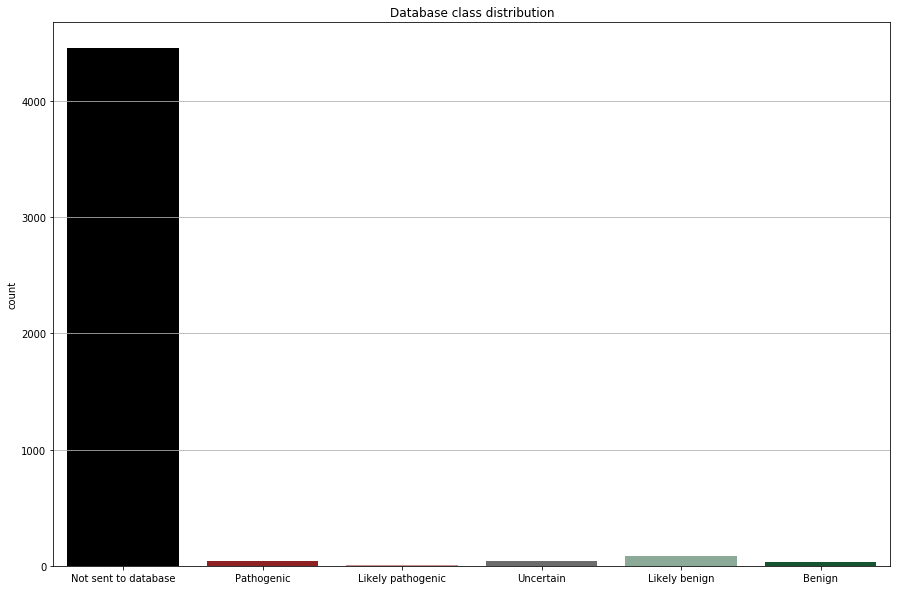

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Database class distribution')
sns.countplot(
    x='database_classification_names', 
    data=df, 
    palette=CLASS_NAMES_COLOR_DICT,
    order=CLASSES_NAMES_ORDER
)
ax.set_xlabel('')
plt.show()

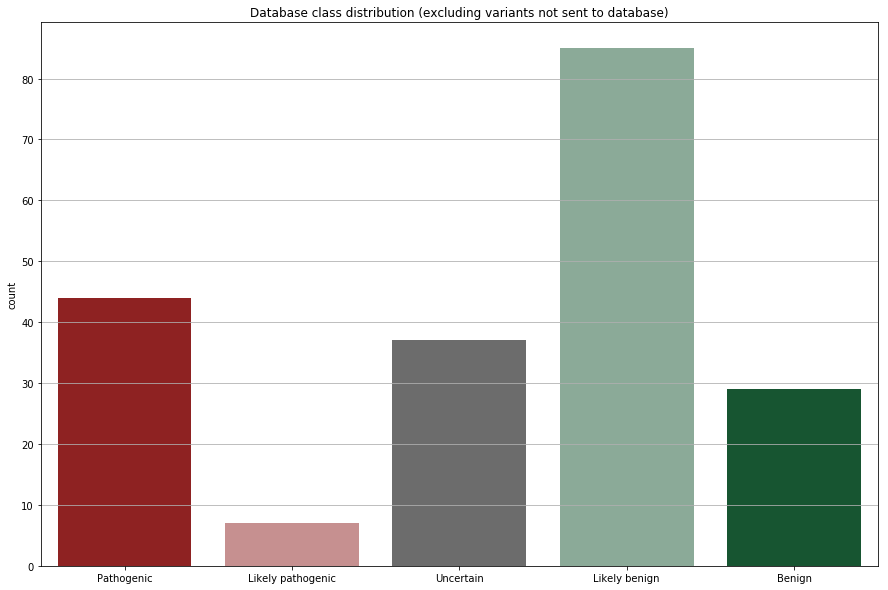

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Database class distribution (excluding variants not sent to database)')
sns.countplot(
    x='database_classification_names', 
    data=df[df['database_classification'] != 0], 
    palette=CLASS_NAMES_COLOR_DICT,
    order=CLASSES_NAMES_ORDER[1:]
)
ax.set_xlabel('')
plt.show()

___

## 2.2 Read depth distribution

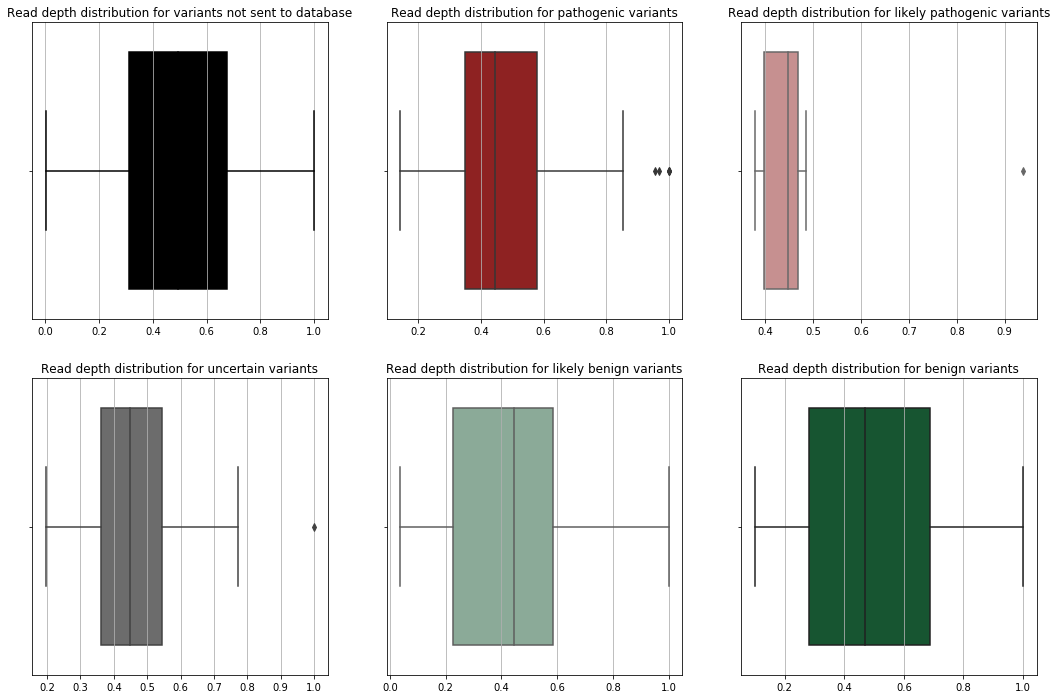

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Read depth distribution for {}'.format(variant_class_string))
    sns.boxplot(
        ax=ax,
        x='norm_read_depth', 
        data=df[df['database_classification'] == database_class], 
        color=CLASSES_COLOR_DICT[database_class]
    )
    
    ax.set_xlabel('')
plt.show()

## 2.3 Allele frequency distribution

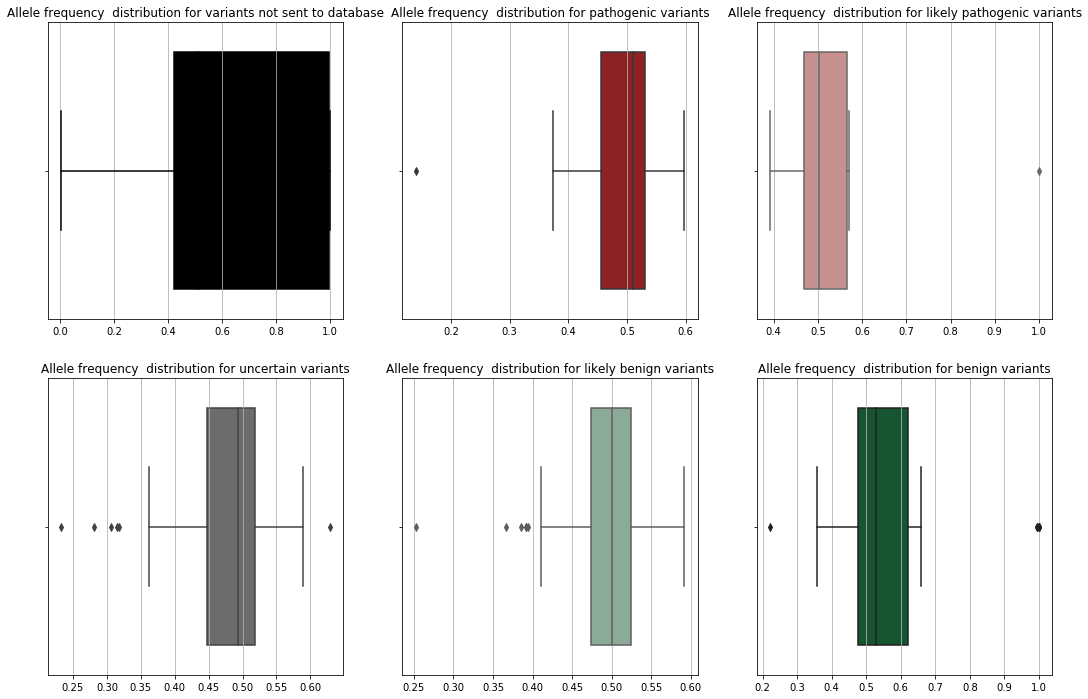

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Allele frequency  distribution for {}'.format(variant_class_string))
    sns.boxplot(
        ax=ax,
        x='allele_frequency', 
        data=df[df['database_classification'] == database_class], 
        color=CLASSES_COLOR_DICT[database_class]
    )
    
    ax.set_xlabel('')
plt.show()

## 2.4 Gene distribution

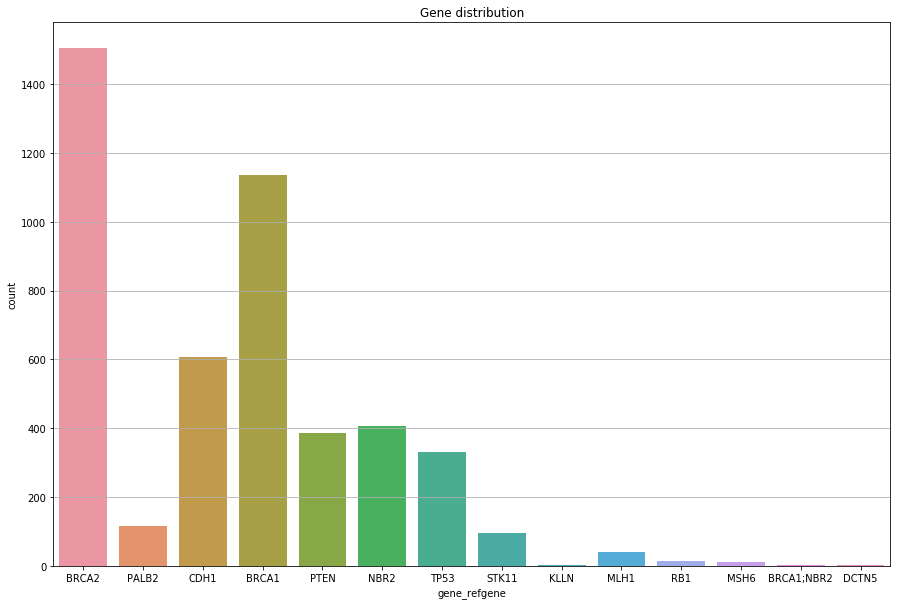

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Gene distribution')
sns.countplot(x='gene_refgene', data=df)
plt.show()

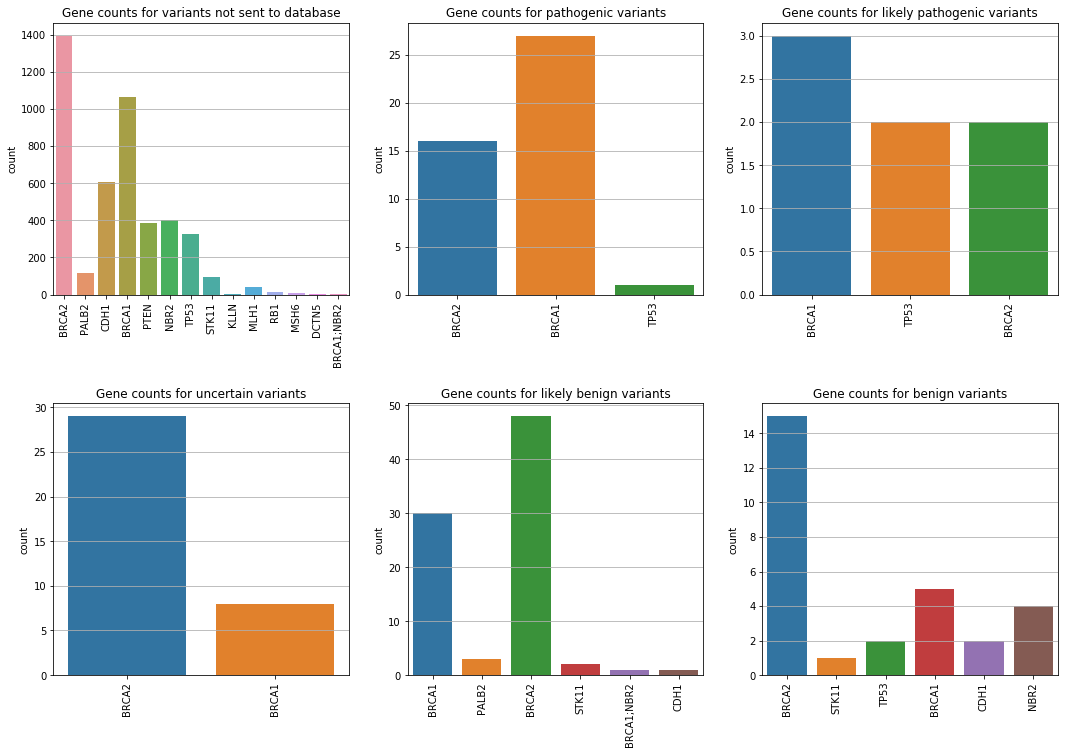

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Gene counts for {}'.format(variant_class_string))
    sns.countplot(
        ax=ax,
        x='gene_refgene', 
        data=df[df['database_classification'] == database_class],
    )
    plt.xticks(rotation=90)
    ax.set_xlabel('')
plt.subplots_adjust(hspace = 0.4)
plt.show()

## 2.5 Variant length distribution

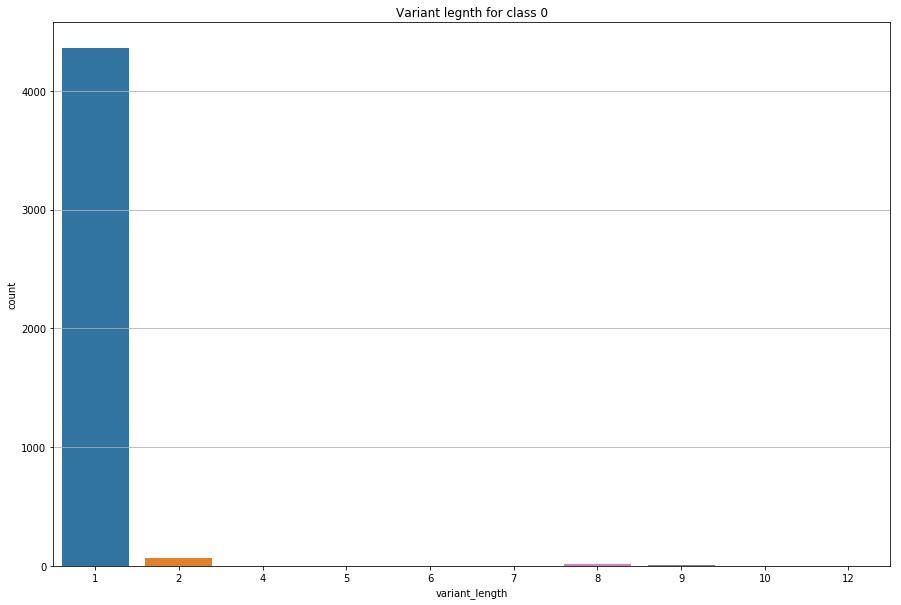

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Variant legnth for class 0')
sns.countplot(x='variant_length', data=df[df['database_classification'] == 0])
plt.show()

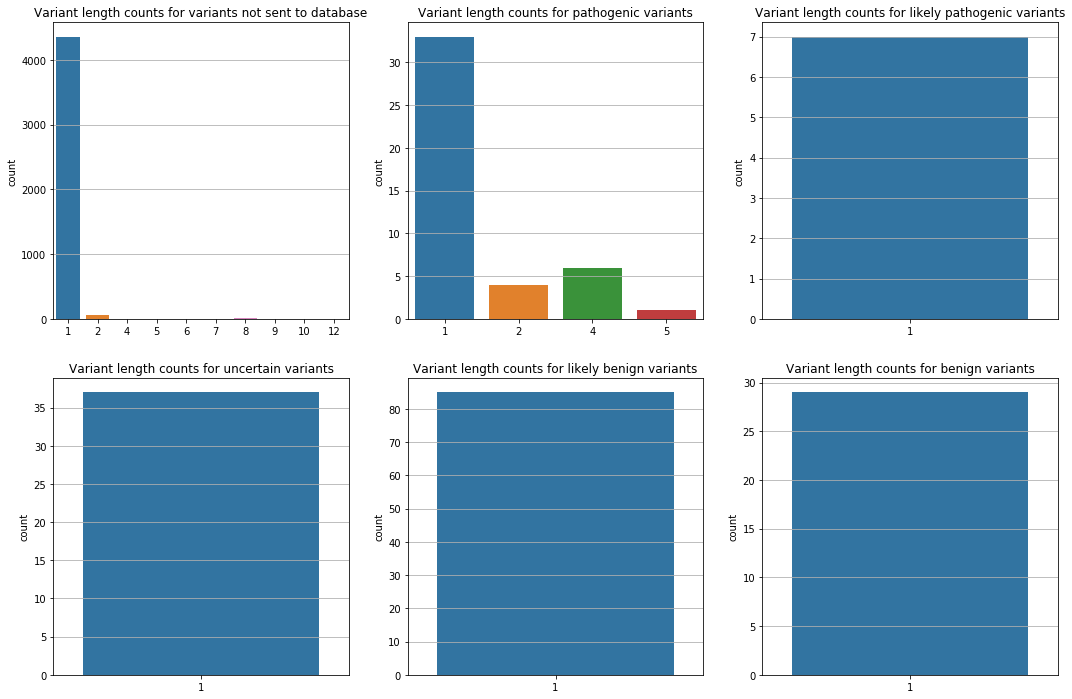

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Variant length counts for {}'.format(variant_class_string))
    sns.countplot(
        ax=ax,
        x='variant_length', 
        data=df[df['database_classification'] == database_class],
    )
    ax.set_xlabel('')
plt.show()

## 2.6 Mutation function distribution

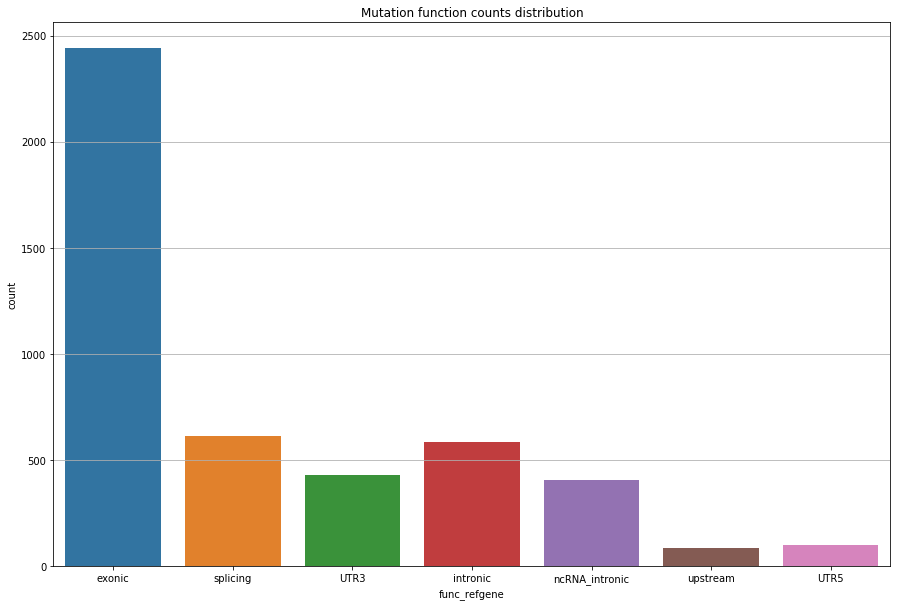

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Mutation function counts distribution')
sns.countplot(x='func_refgene', data=df)
plt.show()

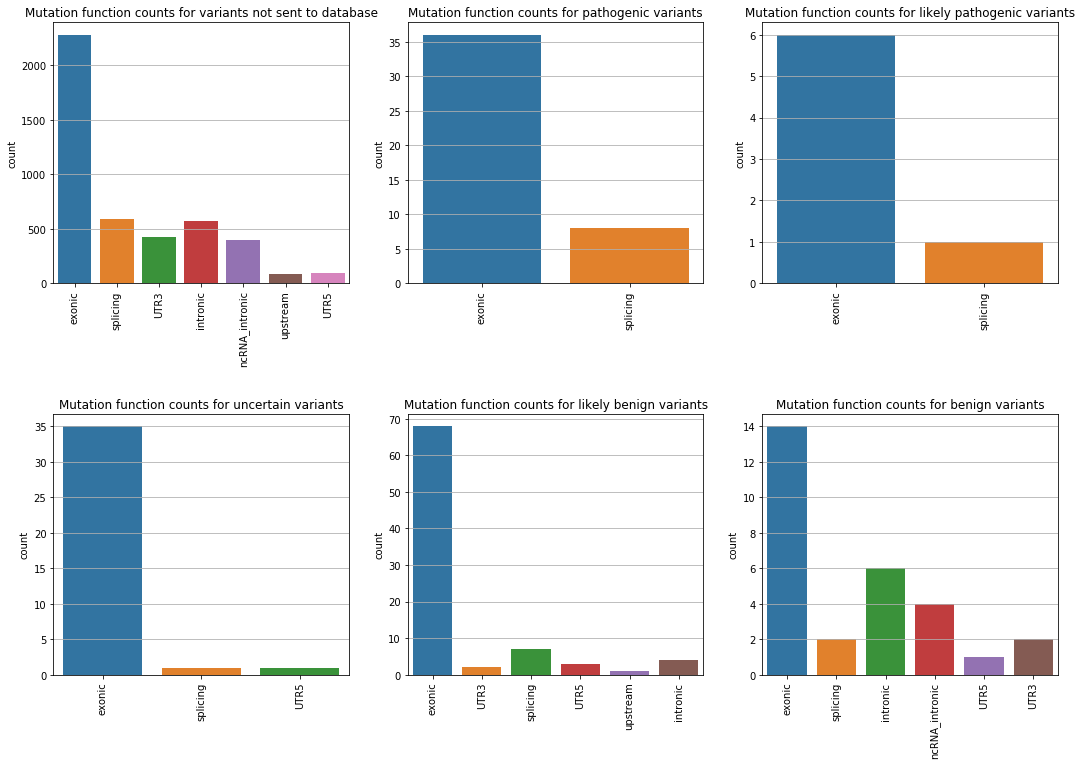

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Mutation function counts for {}'.format(variant_class_string))
    sns.countplot(
        ax=ax,
        x='func_refgene', 
        data=df[df['database_classification'] == database_class],
    )
    plt.xticks(rotation=90)
    ax.set_xlabel('')
plt.subplots_adjust(hspace = 0.5)
plt.show()

## 2.7 Exonic function distribution

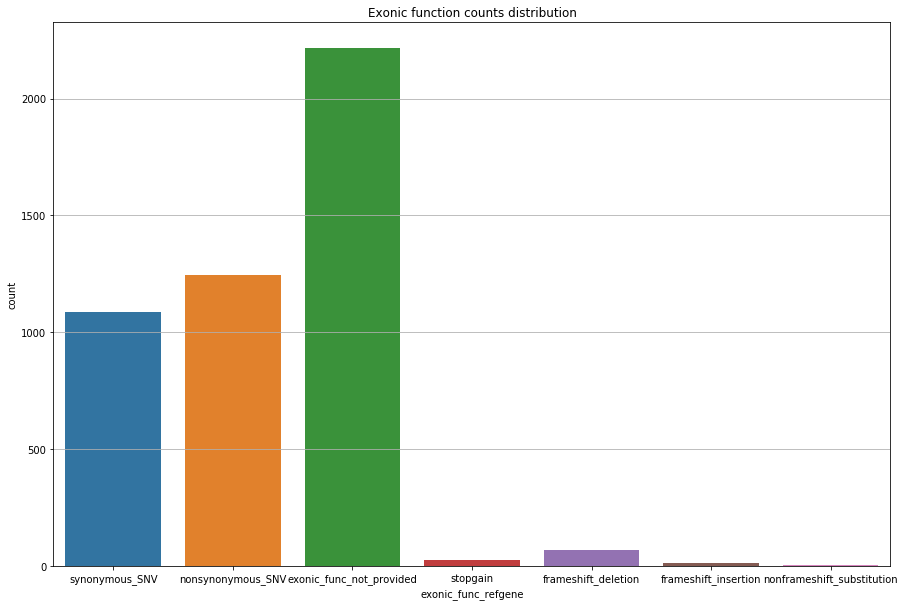

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Exonic function counts distribution')
sns.countplot(x='exonic_func_refgene', data=df)
plt.show()

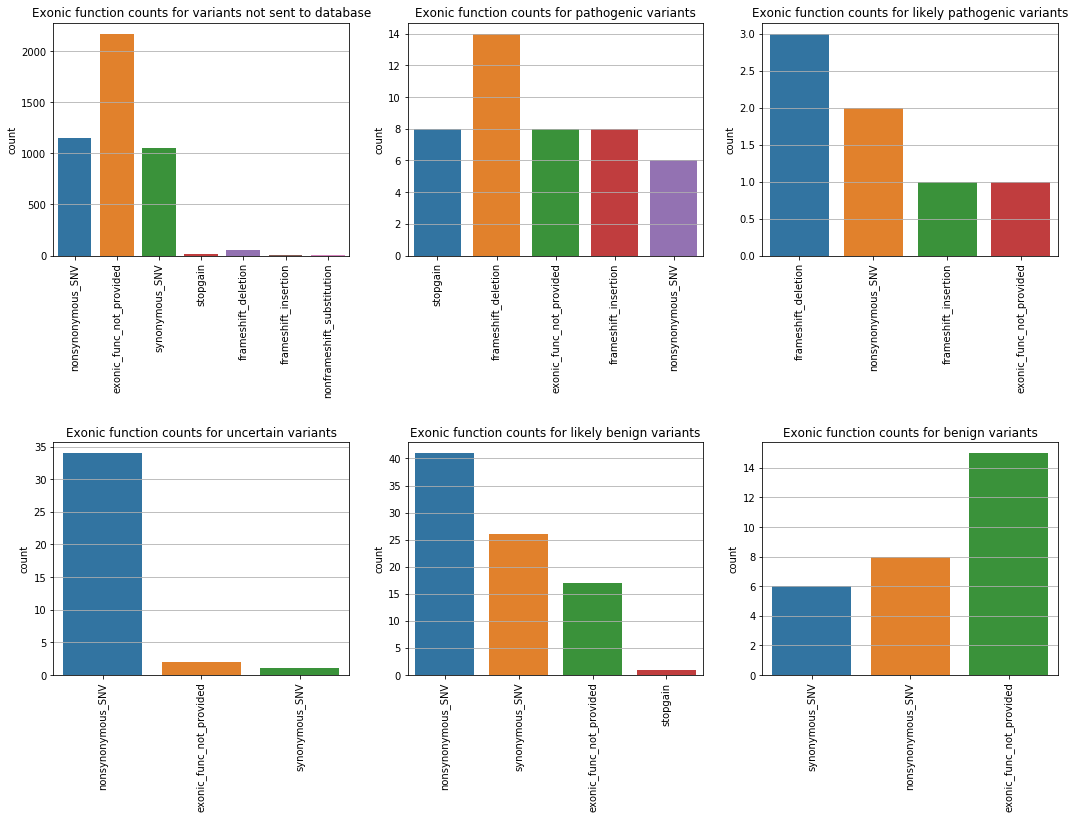

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Exonic function counts for {}'.format(variant_class_string))
    sns.countplot(
        ax=ax,
        x='exonic_func_refgene', 
        data=df[df['database_classification'] == database_class],
    )
    plt.xticks(rotation=90)
    ax.set_xlabel('')
plt.subplots_adjust(hspace = 0.8)
plt.show()

___

## 2.8 Aggregate ClinVar records

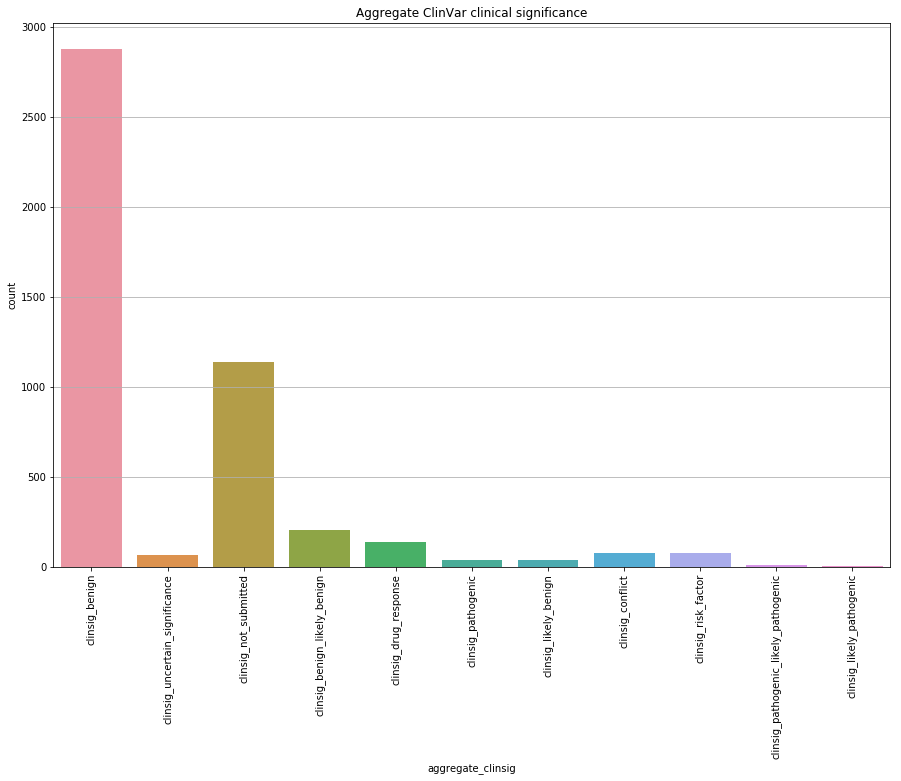

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('Aggregate ClinVar clinical significance')
sns.countplot(x='aggregate_clinsig', data=df)
plt.xticks(rotation=90)
plt.show()

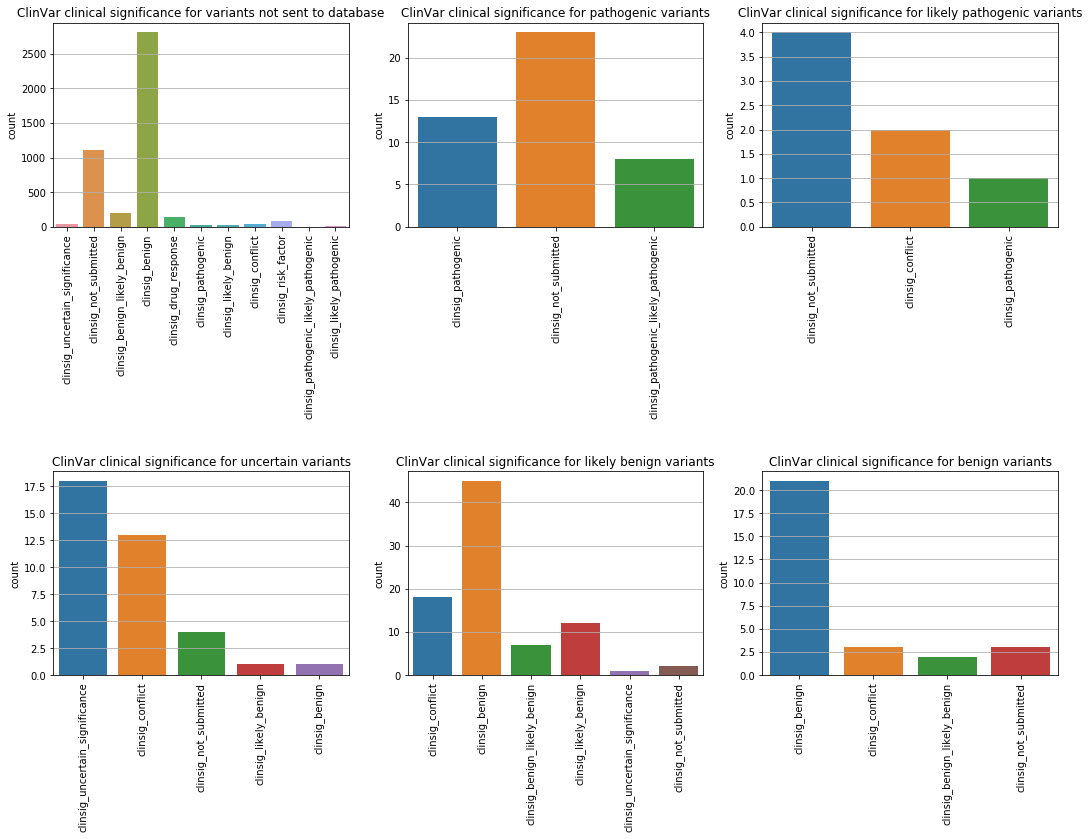

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('ClinVar clinical significance for {}'.format(variant_class_string))
    sns.countplot(
        ax=ax,
        x='aggregate_clinsig', 
        data=df[df['database_classification'] == database_class],
    )
    plt.xticks(rotation=90)
    ax.set_xlabel('')
plt.subplots_adjust(hspace = 1.2)
plt.show()

___

## 2.9 Populational frequency distribution

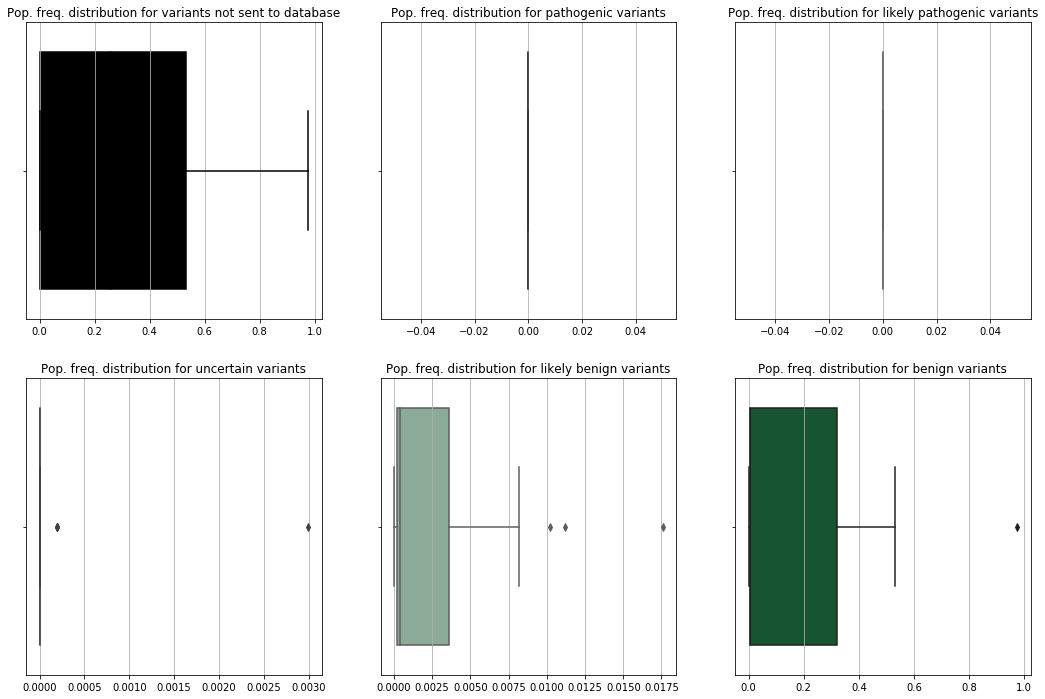

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('Pop. freq. distribution for {}'.format(variant_class_string))
    sns.boxplot(
        ax=ax,
        x='1000genomes', 
        data=df[df['database_classification'] == database_class], 
        color=CLASSES_COLOR_DICT[database_class]
    )
    
    ax.set_xlabel('')
plt.show()

___

## 2.10 VEST score distribution

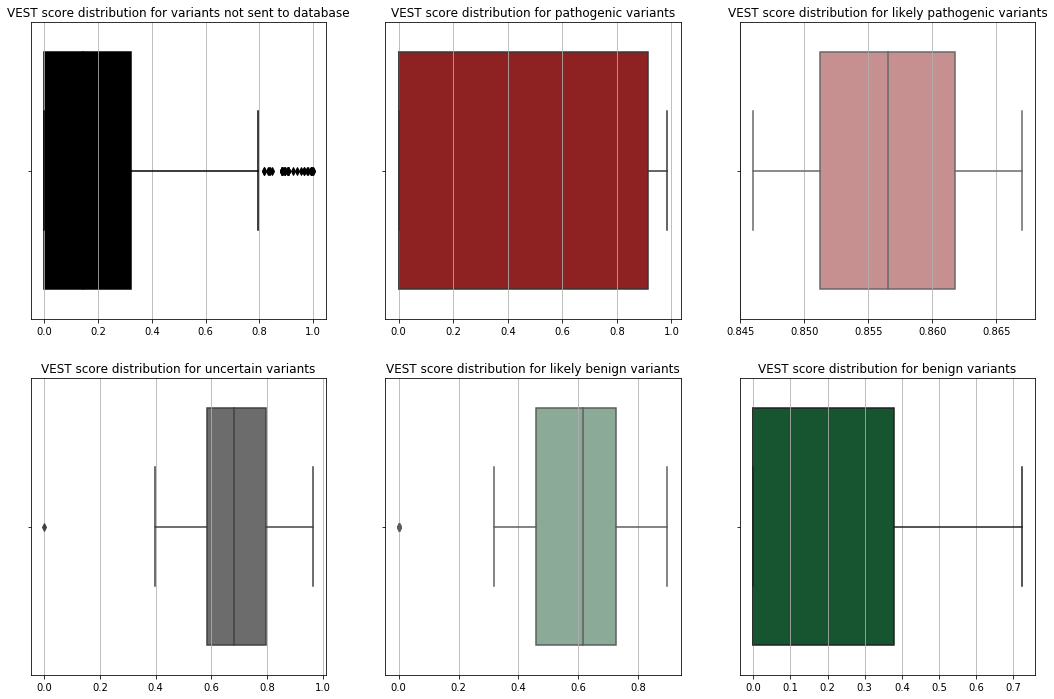

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('VEST score distribution for {}'.format(variant_class_string))
    sns.boxplot(
        ax=ax,
        x='vest3_rankscore', 
        data=df[df['database_classification'] == database_class], 
        color=CLASSES_COLOR_DICT[database_class]
    )
    
    ax.set_xlabel('')
plt.show()

## 2.11 COSMIC cancer counts

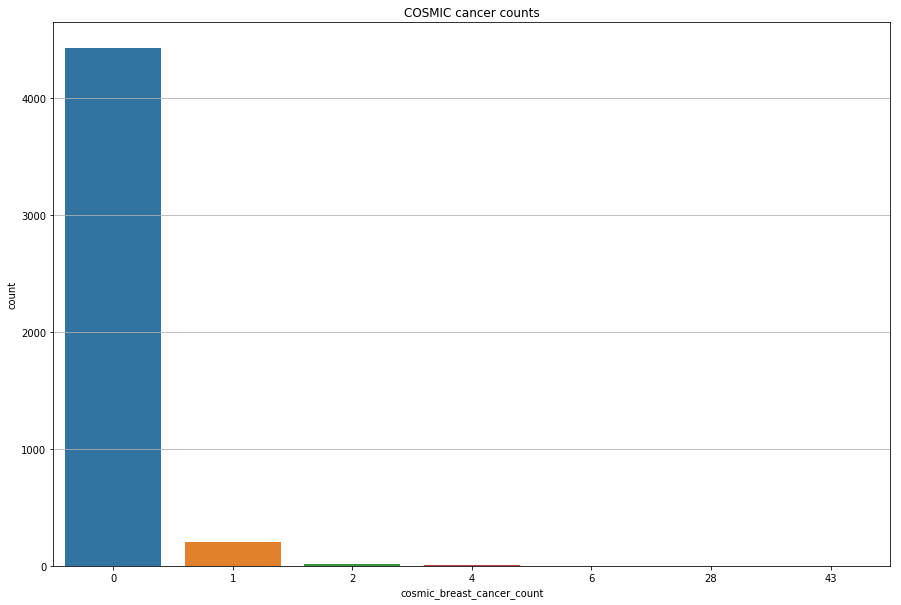

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)
plt.title('COSMIC cancer counts')
sns.countplot(x='cosmic_breast_cancer_count', data=df)
plt.show()

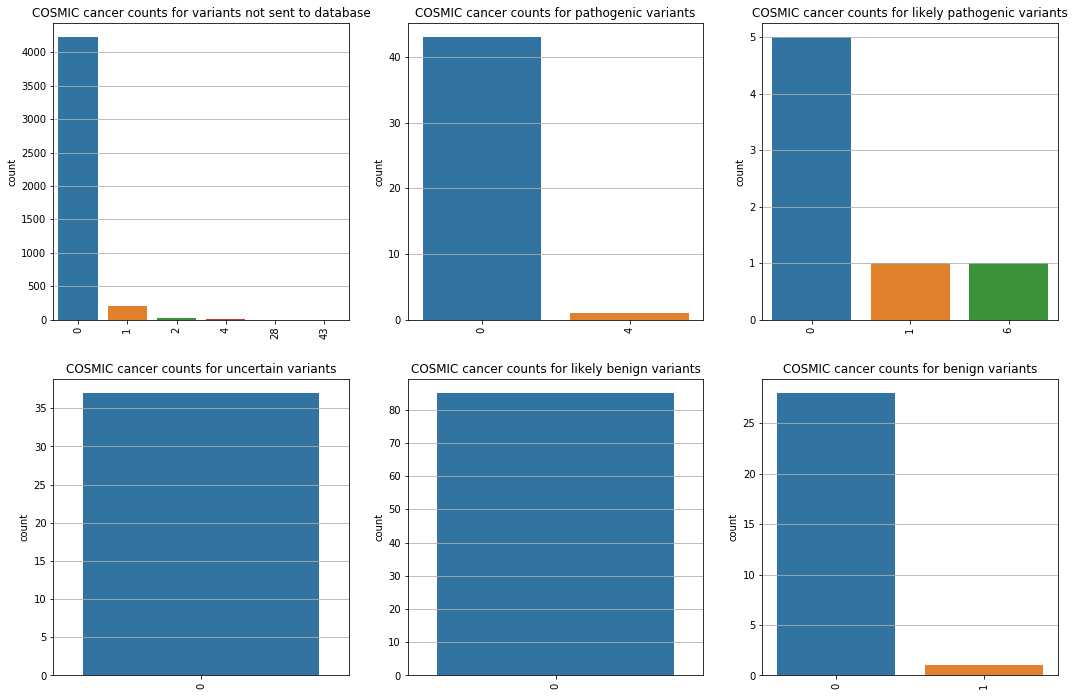

In [0]:
fig = plt.figure(figsize=(18, 12))
for database_class in range(N_CLASSES):
    ax = fig.add_subplot(2, 3, database_class + 1)
    ax.grid(True)
    variant_class_string = '{} variants'.format(CLASSES_NAMES_DICT[database_class].lower())
    if database_class == 0:
        variant_class_string = 'variants {}'.format(CLASSES_NAMES_DICT[database_class].lower())
    plt.title('COSMIC cancer counts for {}'.format(variant_class_string))
    sns.countplot(
        ax=ax,
        x='cosmic_breast_cancer_count', 
        data=df[df['database_classification'] == database_class],
    )
    plt.xticks(rotation=90)
    ax.set_xlabel('')
# plt.subplots_adjust(hspace = 0.8)
plt.show()

## 2.12 Correlations between features

In [0]:
CLASSIFICATION_COLS = [
    'variant_length', 
    'allele_frequency',
    'norm_read_depth',
    'BRCA1', 'BRCA2', 'CDH1', 'KLLN', 'MLH1', 'MSH6', 'NBR2', 'PALB2', 'PTEN', 'RB1', 'STK11', 'TP53',
    'exonic_func_not_provided', 'frameshift_deletion', 'frameshift_insertion', 'nonsynonymous_SNV', 
    'stopgain', 'synonymous_SNV',
    'UTR3', 'UTR5', 'exonic', 'intronic', 'ncRNA_intronic', 'splicing', 'upstream',
    '1000genomes',
    'vest3_rankscore',
    'cosmic_breast_cancer_count',
    'clinsig_benign', 'clinsig_benign_likely_benign', 'clinsig_conflict',
    'clinsig_drug_response', 'clinsig_likely_benign',
    'clinsig_likely_pathogenic', 'clinsig_not_submitted',
    'clinsig_pathogenic', 'clinsig_pathogenic_likely_pathogenic',
    'clinsig_risk_factor', 'clinsig_uncertain_significance'
]

In [0]:
df['sorted_database_classification'] = df['database_classification'].apply(
    lambda x: 7 if x == 0 else x
)

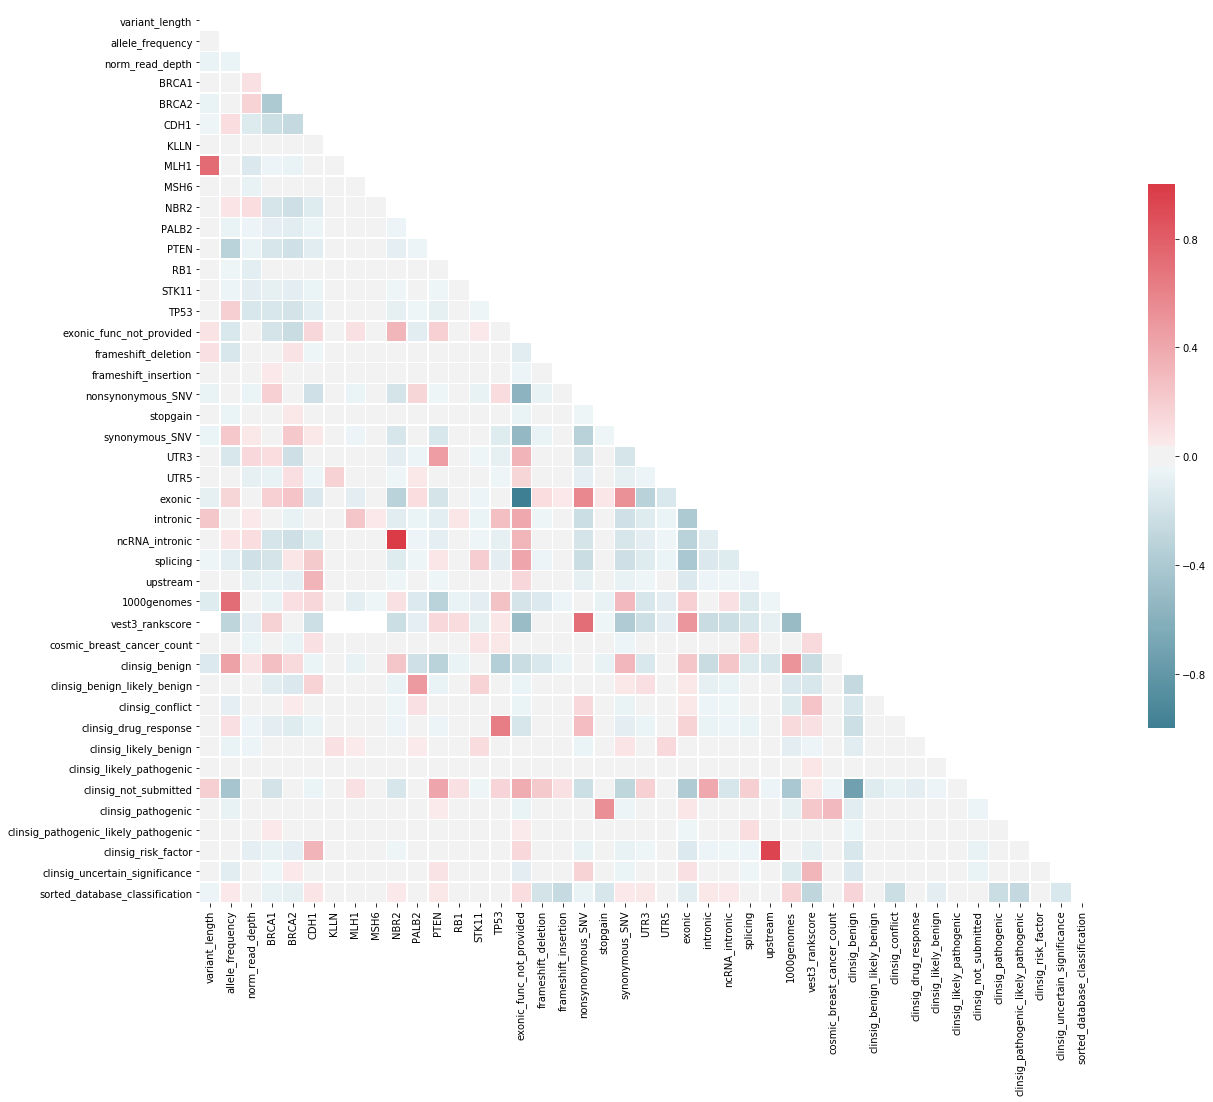

In [0]:
# Compute the correlation matrix
corr = df[CLASSIFICATION_COLS + ['sorted_database_classification']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

___

## 2.13 Classes separability

Dimensionality reduction
[PCA](http://cs229.stanford.edu/notes/cs229-notes10.pdf) + [TSNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)


In [0]:
X = df[(df['database_classification'] != 0)][CLASSIFICATION_COLS].fillna(0).values
y = df[(df['database_classification'] != 0)]['database_classification'].values

print('X.shape', X.shape)
print('y.shape', y.shape)

X.shape (202, 42)
y.shape (202,)


In [0]:
pca = PCA(n_components=30)
X_pca_30 = pca.fit_transform(X)

In [0]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca_30)

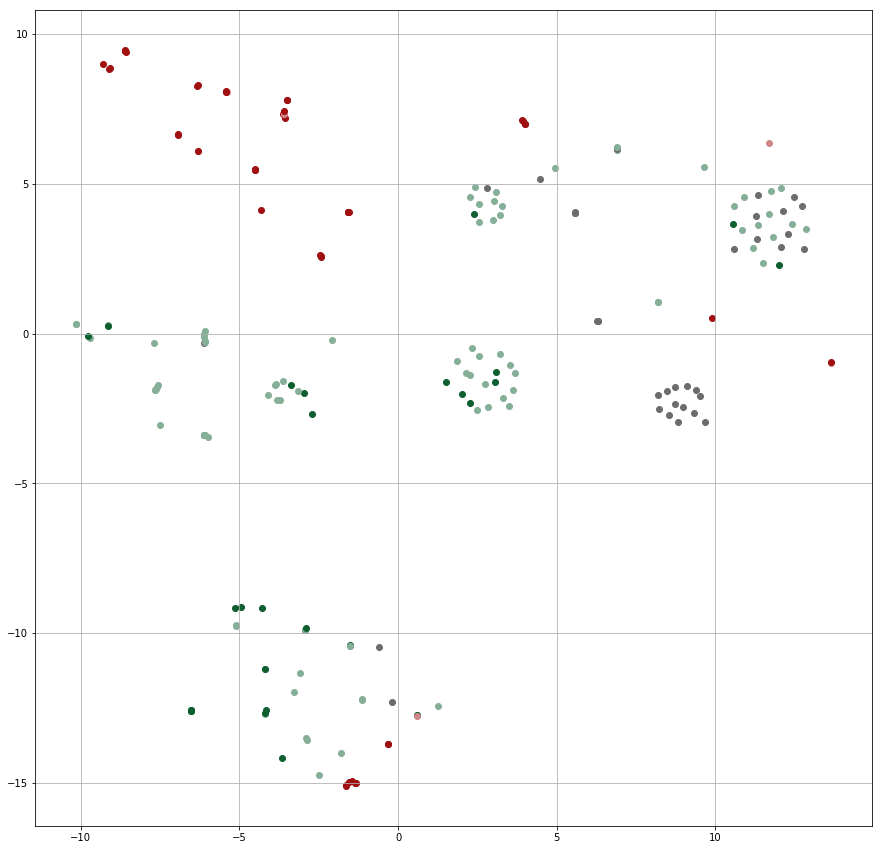

In [0]:
fig = plt.figure(figsize=(15, 15))

for c, (x1, x2) in zip(y, X_tsne):
    plt.scatter(x1, x2, c=CLASSES_COLOR_DICT[c])
plt.grid()
plt.show()

**The End... See you tomorrow =)**